In [ ]:
# import '../config.py

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

#below needed to display decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
# from sklearn.metrics import mean_squared_error

import json
import requests
from bs4 import BeautifulSoup

#import my function files
import webscrape_wiki_table
import config
import query_helper
import time

#utilities file for timer
from utilities import *

/Users/gabrielseemann/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
query_helper.create_db('mushroom')

In [4]:
mushroom_table = """
CREATE TABLE wiki_mush (
    name varchar(200) PRIMARY KEY,
    hymeniumType varchar(100),
    capShape varchar(100),
    whichGills varchar(100),
    stipeCharacter varchar(100),
    sporePrintColor varchar(100),
    ecologicalType varchar(100),
    howEdible varchar(100)
    );
"""

In [5]:
query_helper.create_table(mushroom_table)

Creating a new table
already exists.


## Go through list of links, get data and commit to db

In [6]:
incomplete_data_list =[]


### Get links from Template:Mycomorphbox wiki page

In [9]:
links = ["https://en.wikipedia.org/w/index.php?title=Special:WhatLinksHere/Template:Mycomorphbox&namespace=0&limit=500",
         "https://en.wikipedia.org/w/index.php?title=Special:WhatLinksHere/Template:Mycomorphbox&namespace=0&limit=500&from=23843036&back=0",
         "https://en.wikipedia.org/w/index.php?title=Special:WhatLinksHere/Template:Mycomorphbox&namespace=0&limit=500&from=48473688&back=23843036"]


In [10]:
def scrape_names(link):
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    info = soup.find(id="mw-whatlinkshere-list")
    links = info.find_all('a')
    
    #get names to add to each mushroom page link
    name = []
    for i in range(0, len(links),3):
        name.append(links[i].get_text())
    #append names to link
    list_of_links =[]
    for i in name:
        form_name = i.replace(" ","_")
        list_of_links.append('https://en.wikipedia.org/wiki/{}'.format(form_name))
    
    #scrape each individual mushroom page for deets
    for link in list_of_links:
        raw = webscrape_wiki_table.get_mush_table(link)
        #if data not complete save and go to next link
        if type(raw[0])!= dict:
            incomplete_data_list.append(raw)
            continue
        #else data is clean so commit to db
        query_helper.mush_to_tup(raw)
        
    
    

In [11]:
# We will pass all links to the scrape_names function
Timer.start()
incomplete_data_list =[]
for link in links:
    scrape_names(link)
Timer.end()

639.700 seconds elapsed


## Get elements with incomplete data and store to analyze later

In [16]:
incomplete_data_list
len(incomplete_data_list)

413

In [17]:
#write all incomplete data to json file
with open('data_missing.json', 'w', encoding='utf-8') as f:
    json.dump(incomplete_data_list, f, ensure_ascii=False, indent=4)

In [ ]:
#testing cell
web_address = 'https://en.wikipedia.org/wiki/{}'.format(names_data_miss[0])
page = requests.get(web_address)
soup = BeautifulSoup(page.content, 'html.parser')

### IF IMPORT IS MESSED UP LOOK HERE. ASSUMES mush Box is always second
info = soup.find_all('table',{"class":"infobox"})

#get mushroom name 
name = [i.string for i in info[1].findAll('i')]
print(name)
#get mushroom info
divs = info[1].findAll("td")
stuff= divs[1:]
text = []
for i in stuff:
    text.append(i.get_text())

print(text)
name_and_info = name+text

print(name_and_info)

#catch if only name is missing
if (len(text)==7):
    name = [web_address.split('/')[-1].replace('_', ' ')]
#     print(name)
    name_and_info = name+text
#     print(name_and_info)

#catch incomplete values and return them seperate and add them to a list
if(len(name_and_info)!=8):
    name = [web_address.split('/')[-1].replace('_', ' ')]
    print(name)
    name_and_info =name+text
    print(name_and_info)

name_and_info

### Clean mushroom data

In [142]:
hymeniumType =  ['gills'   
                ,'pores'
                ,'smooth'
                ,'ridges'
                ,'teeth'
                ,'gleba']

In [143]:
capShape =  ['campanulate'
            ,'conical'
            ,'convex'
            ,'depressed'
            ,'flat'
            ,'infundibuliform'
            ,'offset'
            ,'ovate'
            ,'umbilicate'
            ,'umbonate'
            ,'no'
            ,'NA']

In [144]:
whichGills = ['adnate'
            ,'adnexed'
            ,'decurrent'
            ,'emarginate'
            ,'free'
            ,'seceding'
            ,'sinuate'
            ,'subdecurrent'
            ,'no'
            ,'NA']

In [145]:
stipeCharacter = ['bare'
                ,'ring'
                ,'volva'
                ,'ring_and_volva'
                ,'cortina'
                ,'NA']

In [146]:
sporePrintColor = ['black'
                    ,'blackish-brown'
                    ,'brown'
                    ,'buff'
                    ,'cream'
                    ,'green'
                    ,'ochre'
                    ,'olive'
                    ,'olive-brown'
                    ,'pink'
                    ,'pinkish-brown'
                    ,'purple'
                    ,'purple-black'
                    ,'purple-brown'
                    ,'reddish-brown'
                    ,'salmon'
                    ,'tan'
                    ,'white'
                    ,'yellow'
                    ,'yellow-orange'
                    ,'yellow-brown']

In [147]:
ecologicalType =['mycorrhizal'
                ,'parasitic'
                ,'saprotrophic']

In [148]:
howEdible = ['choice'
            ,'edible'
            ,'inedible'
            ,'unpalatable'
            ,'caution'
            ,'psychoactive'
            ,'poisonous'
            ,'allergenic'
            ,'deadly'
            ,'unknown']

In [149]:
mushroom_features = [hymeniumType, capShape, whichGills, stipeCharacter, sporePrintColor, ecologicalType, howEdible]

In [150]:
query ='''SELECT * FROM mushroom.wiki_mush;)'''

In [151]:
from collections import Counter

In [152]:
df = query_helper.query_to_df(query)
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
0,Lysurus mokusin,smooth hymenium,no distinct cap,hymenium attachment is irregular or not applic...,stipe is bare,spore print is olive-brown,ecology is saprotrophic,edibility: unknown
1,Agaricus abruptibulbus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible
2,Agaricus amicosus,gills on hymenium,cap is convex\n or flat,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: choice
3,Agaricus arvensis,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown\n to blackish-brown,ecology is saprotrophic,edibility: choice
4,Agaricus augustus,gills on hymenium,cap is convex,hymenium is free,stipe has a ring,spore print is brown,ecology is saprotrophic,edibility: edible


In [153]:
#pull feature out of string **LIMITED TO FIRST MATCH CURRENTLY
def get_feature_type(feature, instance):
    #clean string
    s = instance.replace('\n', ' ') 
    s = s.split()
    
    #find match
    for catagory in feature:
        if catagory in s:
            feat = catagory
            return feat
    return '0'

## Take only feature out of each string

In [154]:
for features, col in zip(mushroom_features, df.columns[1:]):
#     print(i)
    df[col] = df[col].apply(lambda x: get_feature_type(features, x))

In [157]:
df.sporePrintColor.value_counts()

white             287
brown              87
cream              36
purple-brown       35
olive-brown        32
black              28
pink               21
reddish-brown      20
yellow             19
olive              15
buff               14
blackish-brown     14
tan                 7
yellow-orange       7
ochre               5
purple              4
purple-black        4
pinkish-brown       2
salmon              2
yellow-brown        2
green               1
Name: sporePrintColor, dtype: int64

In [158]:
#map edibiliy to binary groups
df.loc[:,'howEdible'] = df.howEdible.map(lambda x : {
    'edible'      : 'edible',
    'choice'      : 'edible',
    'psychoactive': 'edible',
    'inedible'    : 'inedible',
    'poisonous'   : 'inedible',
    'unknown'     : 'inedible',
    'deadly'      : 'inedible',
    '0'           : 'inedible',
    'unpalatable' : 'inedible'
}[x])

In [159]:
df.howEdible.value_counts()

inedible    330
edible      312
Name: howEdible, dtype: int64

In [160]:
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
0,Lysurus mokusin,smooth,no,0,bare,olive-brown,saprotrophic,inedible
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,edible
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,edible
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible


In [161]:
df.describe()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible
count,642,642,642,642,642,642,642,642
unique,642,6,11,9,5,21,3,2
top,Amanita australis,gills,convex,adnate,bare,white,saprotrophic,inedible
freq,1,484,342,241,426,287,319,330


In [162]:
df['genus']= '0'
df['genus']= df['name'].apply(lambda x: (x.split()[0]) if len(x.split())==2 else '0')

In [163]:
df.head()

,name,hymeniumType,capShape,whichGills,stipeCharacter,sporePrintColor,ecologicalType,howEdible,genus
0,Lysurus mokusin,smooth,no,0,bare,olive-brown,saprotrophic,inedible,Lysurus
1,Agaricus abruptibulbus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
2,Agaricus amicosus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus
3,Agaricus arvensis,gills,convex,free,ring,blackish-brown,saprotrophic,edible,Agaricus
4,Agaricus augustus,gills,convex,free,ring,brown,saprotrophic,edible,Agaricus


## For now will move to analysis

divide data into x and y and training set and get dummies

In [164]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible']))
y = df['howEdible']
data.head()

,hymeniumType_0,hymeniumType_gills,hymeniumType_pores,hymeniumType_ridges,hymeniumType_smooth,hymeniumType_teeth,capShape_campanulate,capShape_conical,capShape_convex,capShape_depressed,...,genus_Tremella,genus_Tricholoma,genus_Tricholomopsis,genus_Turbinellus,genus_Tylopilus,genus_Verpa,genus_Volvariella,genus_Volvopluteus,genus_Xerocomellus,genus_Xerula
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
#break up data for testing and training
data_train, data_test, y_train, y_test = train_test_split(data, y,test_size=.2)

## Regular Tree

In [209]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=30) 
tree_clf.fit(data_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

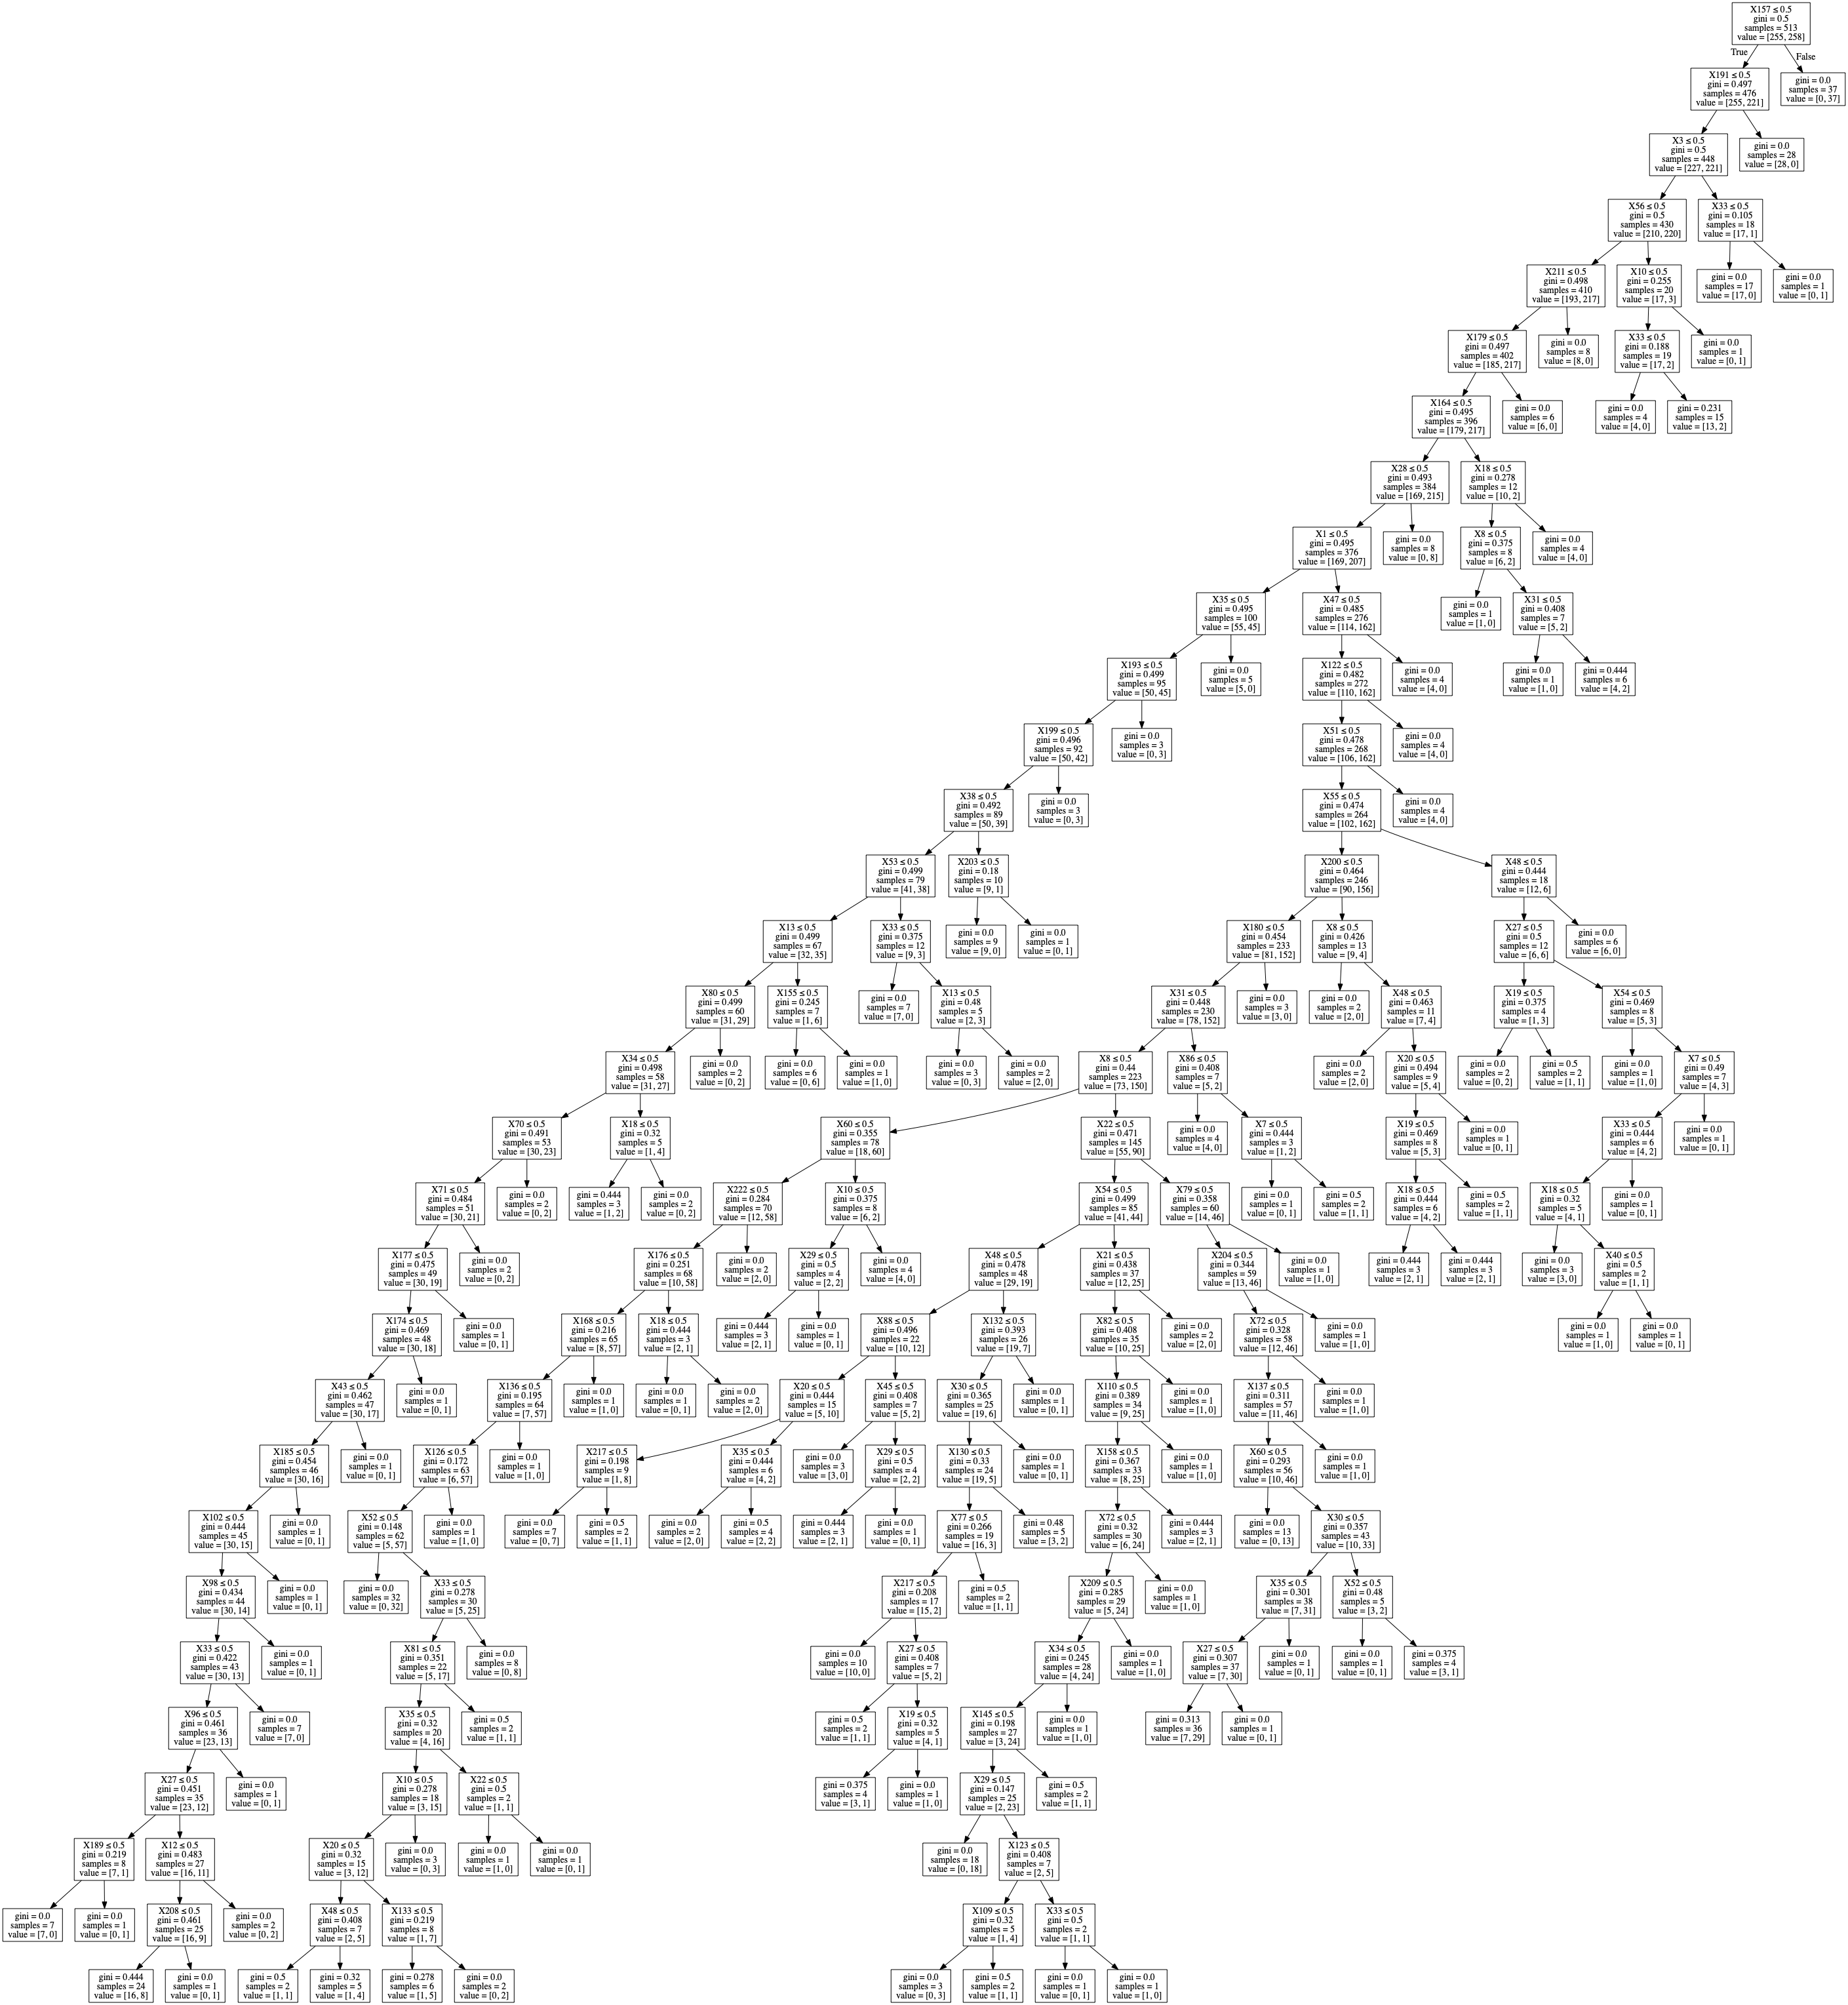

In [210]:
# visualizing the regression tree
dot_data = StringIO()
export_graphviz(tree_clf, out_file=dot_data,  
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

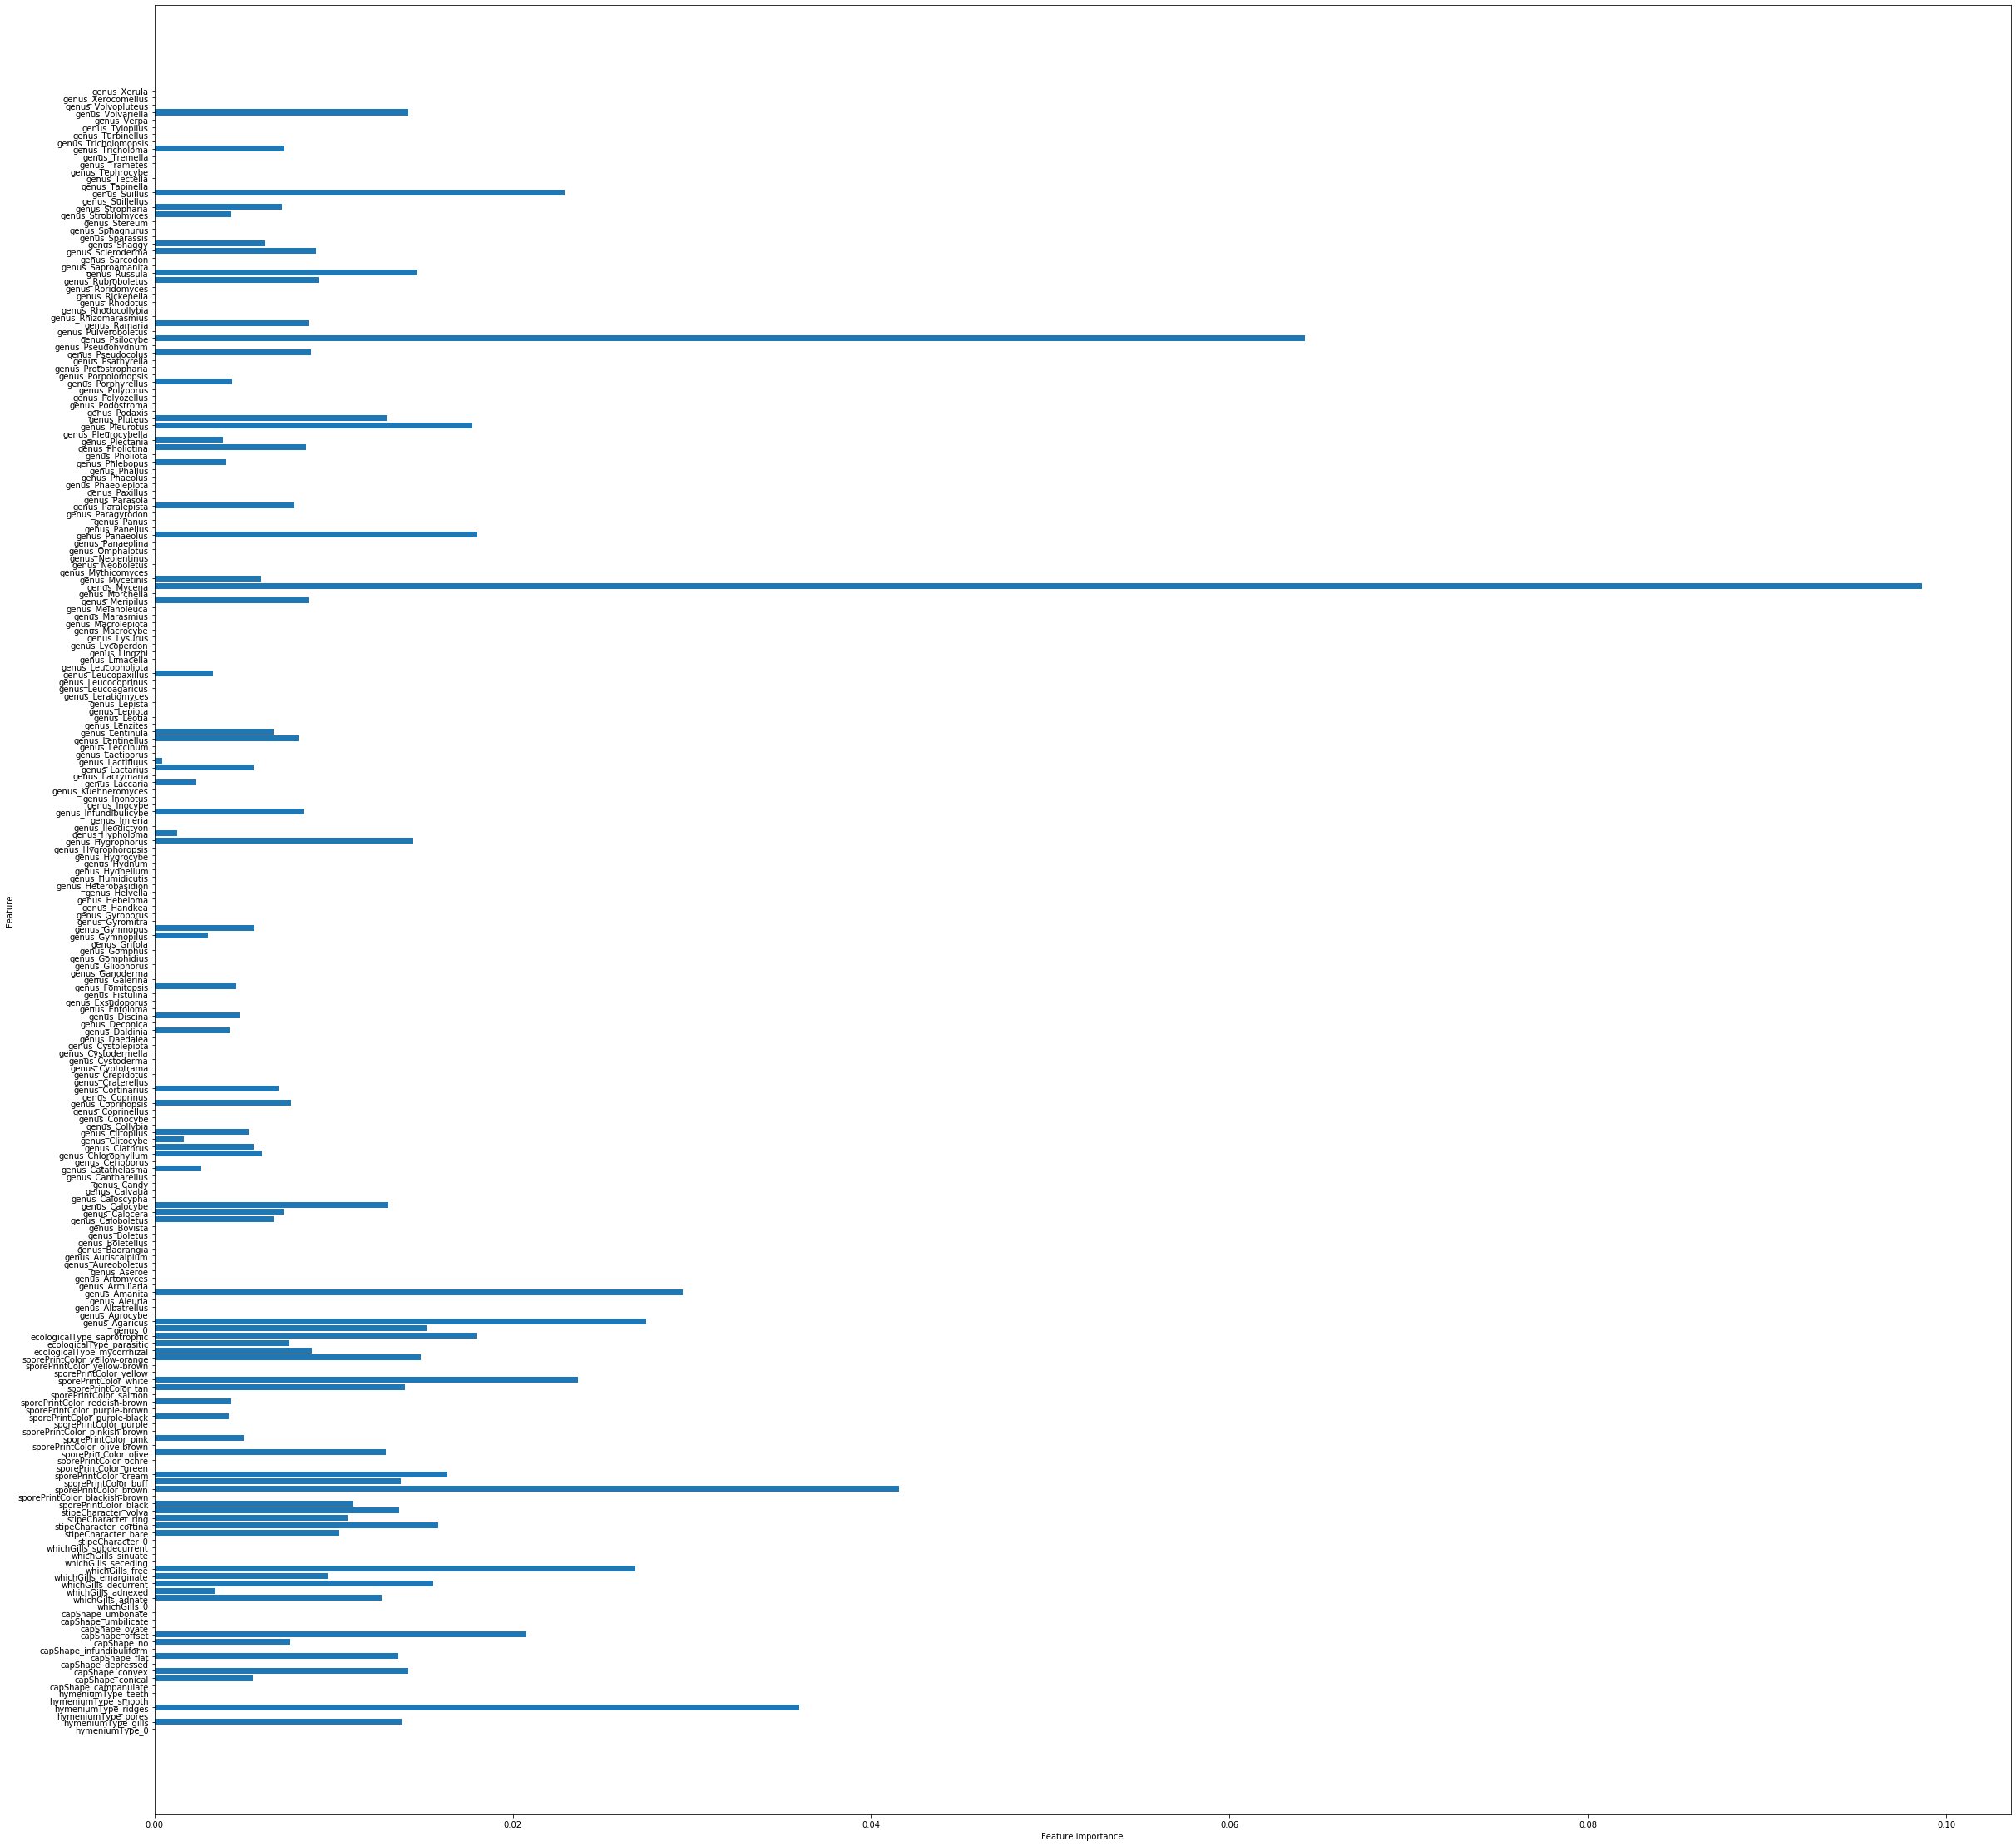

In [211]:
plot_feature_importances(tree_clf)

In [212]:
# Test set predictions
pred = tree_clf.predict(data_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[44 13]
 [36 36]]
              precision    recall  f1-score   support

      edible       0.55      0.77      0.64        57
    inedible       0.73      0.50      0.60        72

    accuracy                           0.62       129
   macro avg       0.64      0.64      0.62       129
weighted avg       0.65      0.62      0.62       129



In [170]:
#function used to plot feature importance
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(40,40))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

## Random Forest

In [171]:
# Instantiate a BaggingClassifier
# bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
#                                  n_estimators=20)

In [172]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=200, max_depth= 10)
forest.fit(data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [173]:
# Training accuracy score
forest.score(data_train, y_train)

0.8791423001949318

In [174]:
# Test accuracy score
forest.score(data_test, y_test)

0.6589147286821705

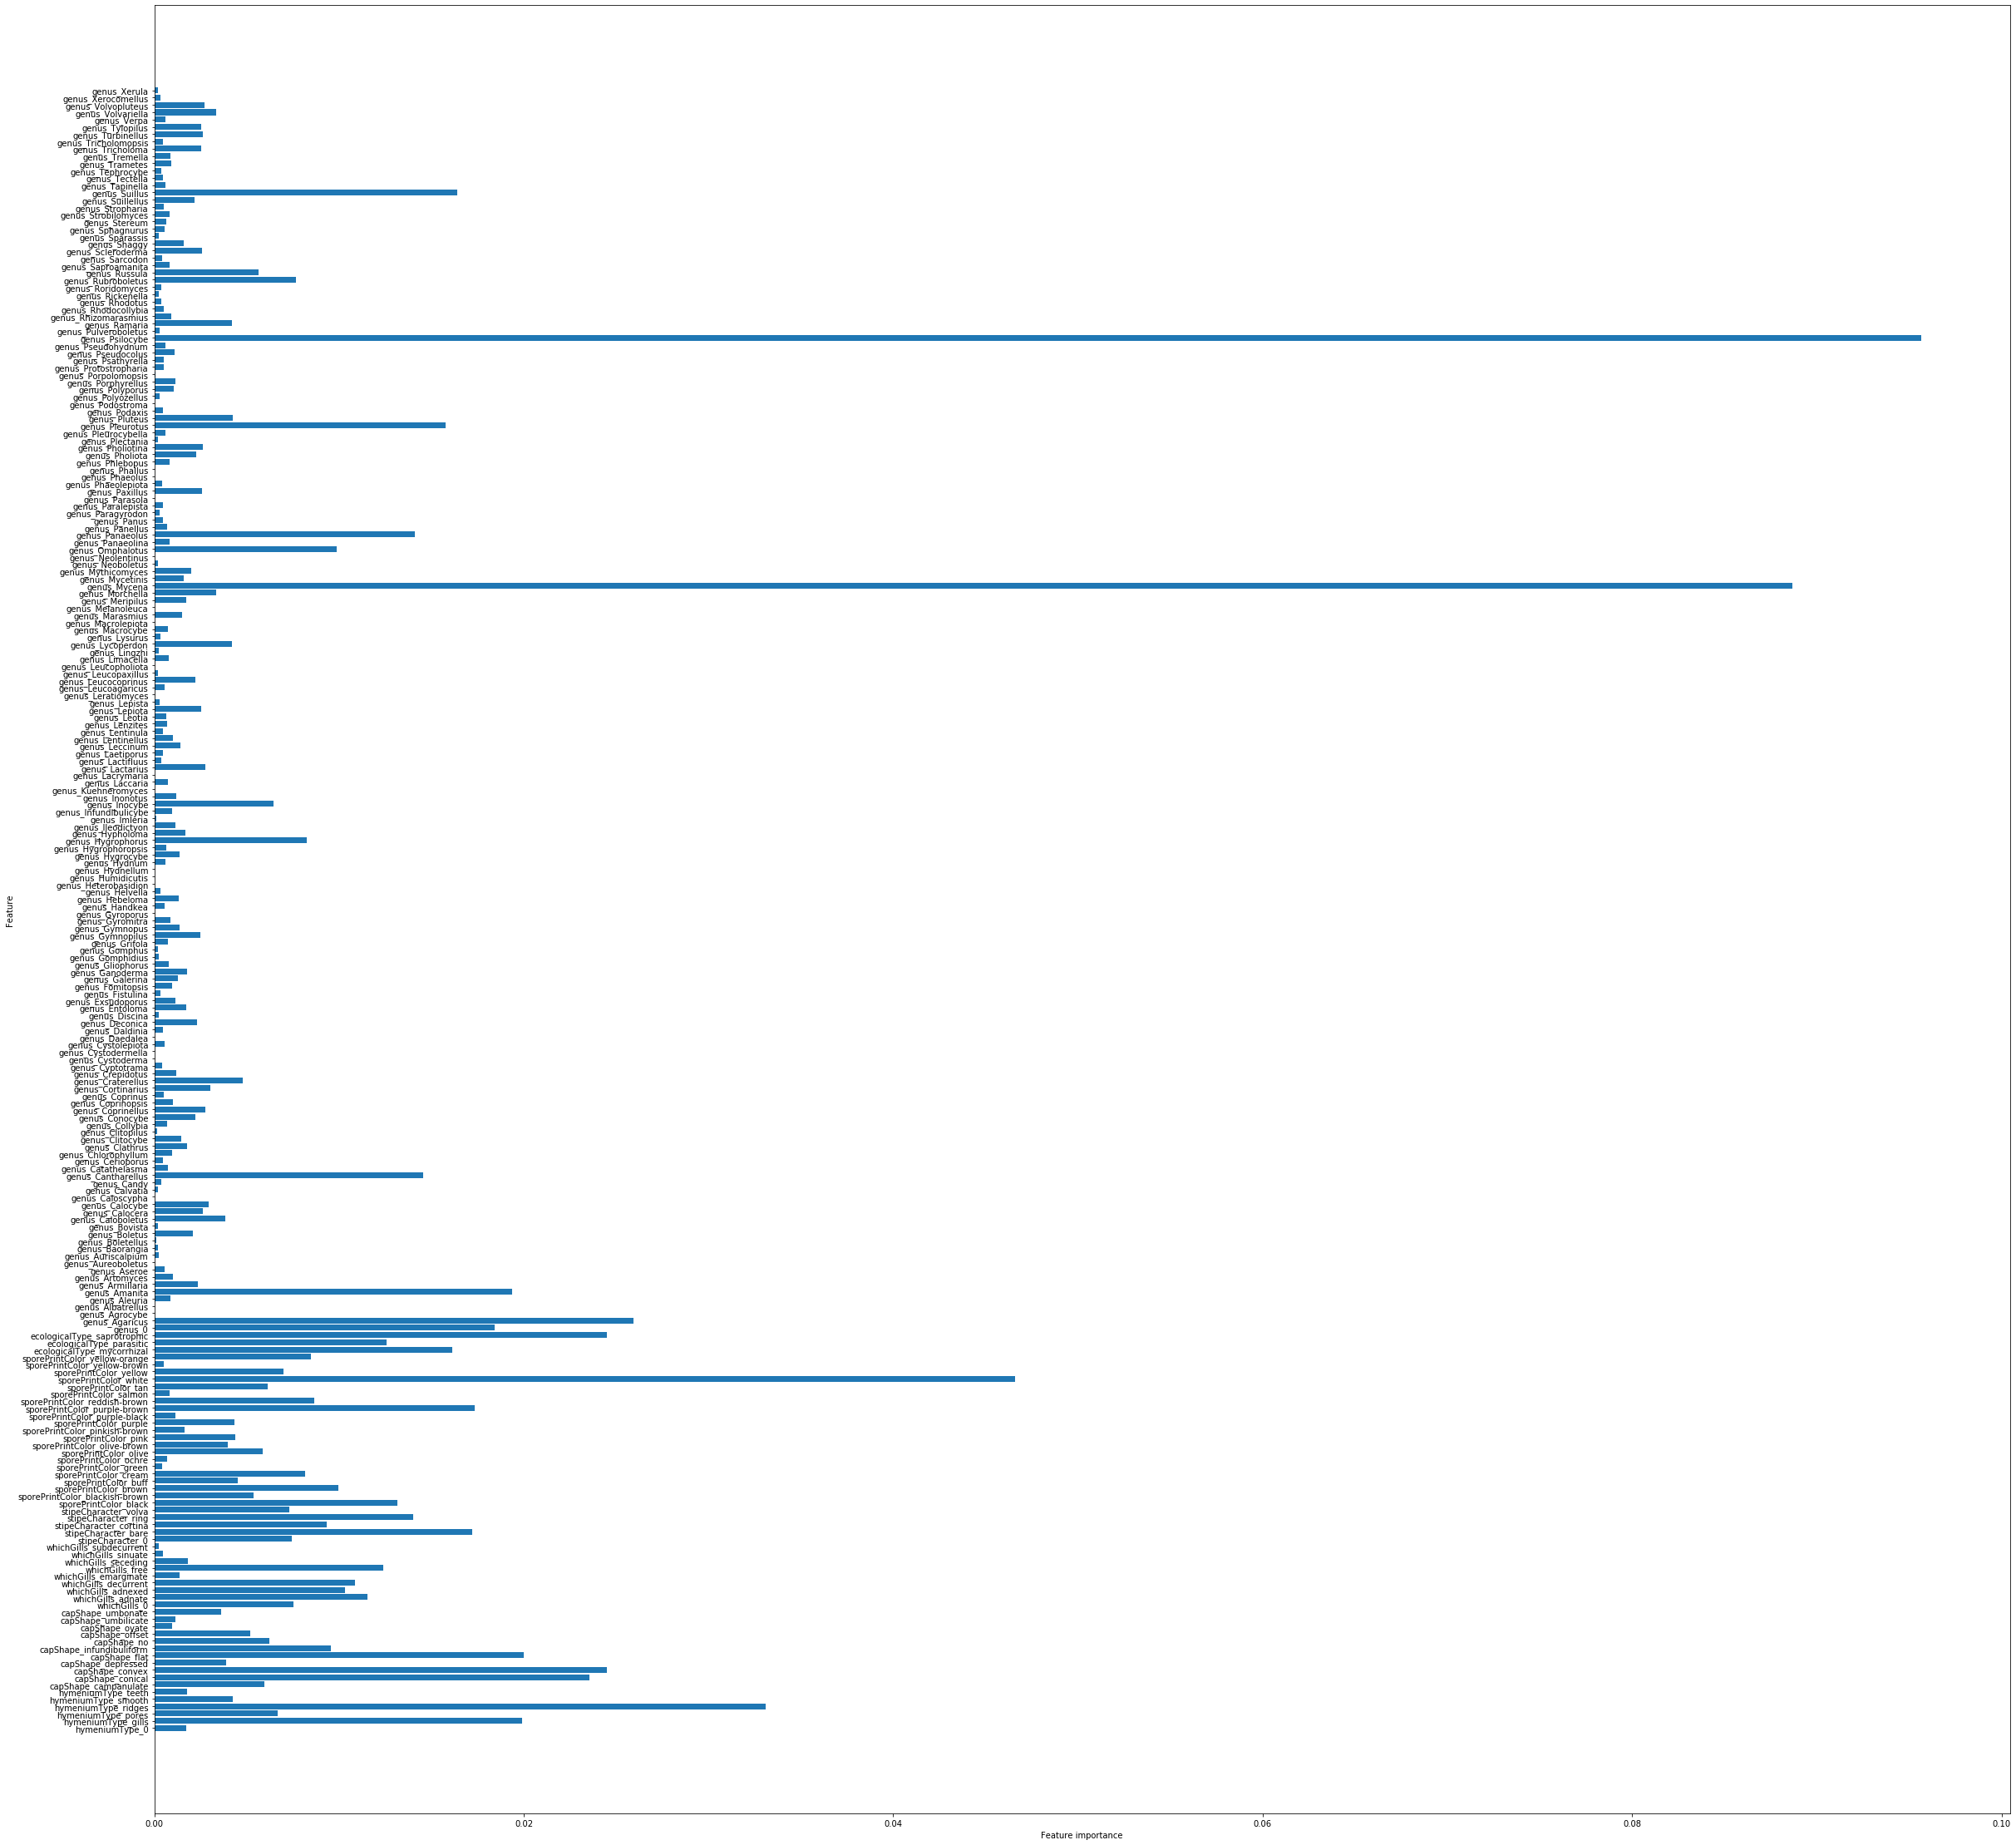

In [175]:
plot_feature_importances(forest)

## Omitting Genus

In [176]:
data = pd.get_dummies(df.drop(columns=['name', 'howEdible', 'genus']))
y = df['howEdible']
data.head()

,hymeniumType_0,hymeniumType_gills,hymeniumType_pores,hymeniumType_ridges,hymeniumType_smooth,hymeniumType_teeth,capShape_campanulate,capShape_conical,capShape_convex,capShape_depressed,...,sporePrintColor_reddish-brown,sporePrintColor_salmon,sporePrintColor_tan,sporePrintColor_white,sporePrintColor_yellow,sporePrintColor_yellow-brown,sporePrintColor_yellow-orange,ecologicalType_mycorrhizal,ecologicalType_parasitic,ecologicalType_saprotrophic
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Mushroom Observer Database

In [205]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=200, max_depth= 10)
forest.fit(data_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [206]:
# Training accuracy score
forest.score(data_train, y_train)

0.8771929824561403

In [207]:
# Test accuracy score
forest.score(data_test, y_test)

0.689922480620155

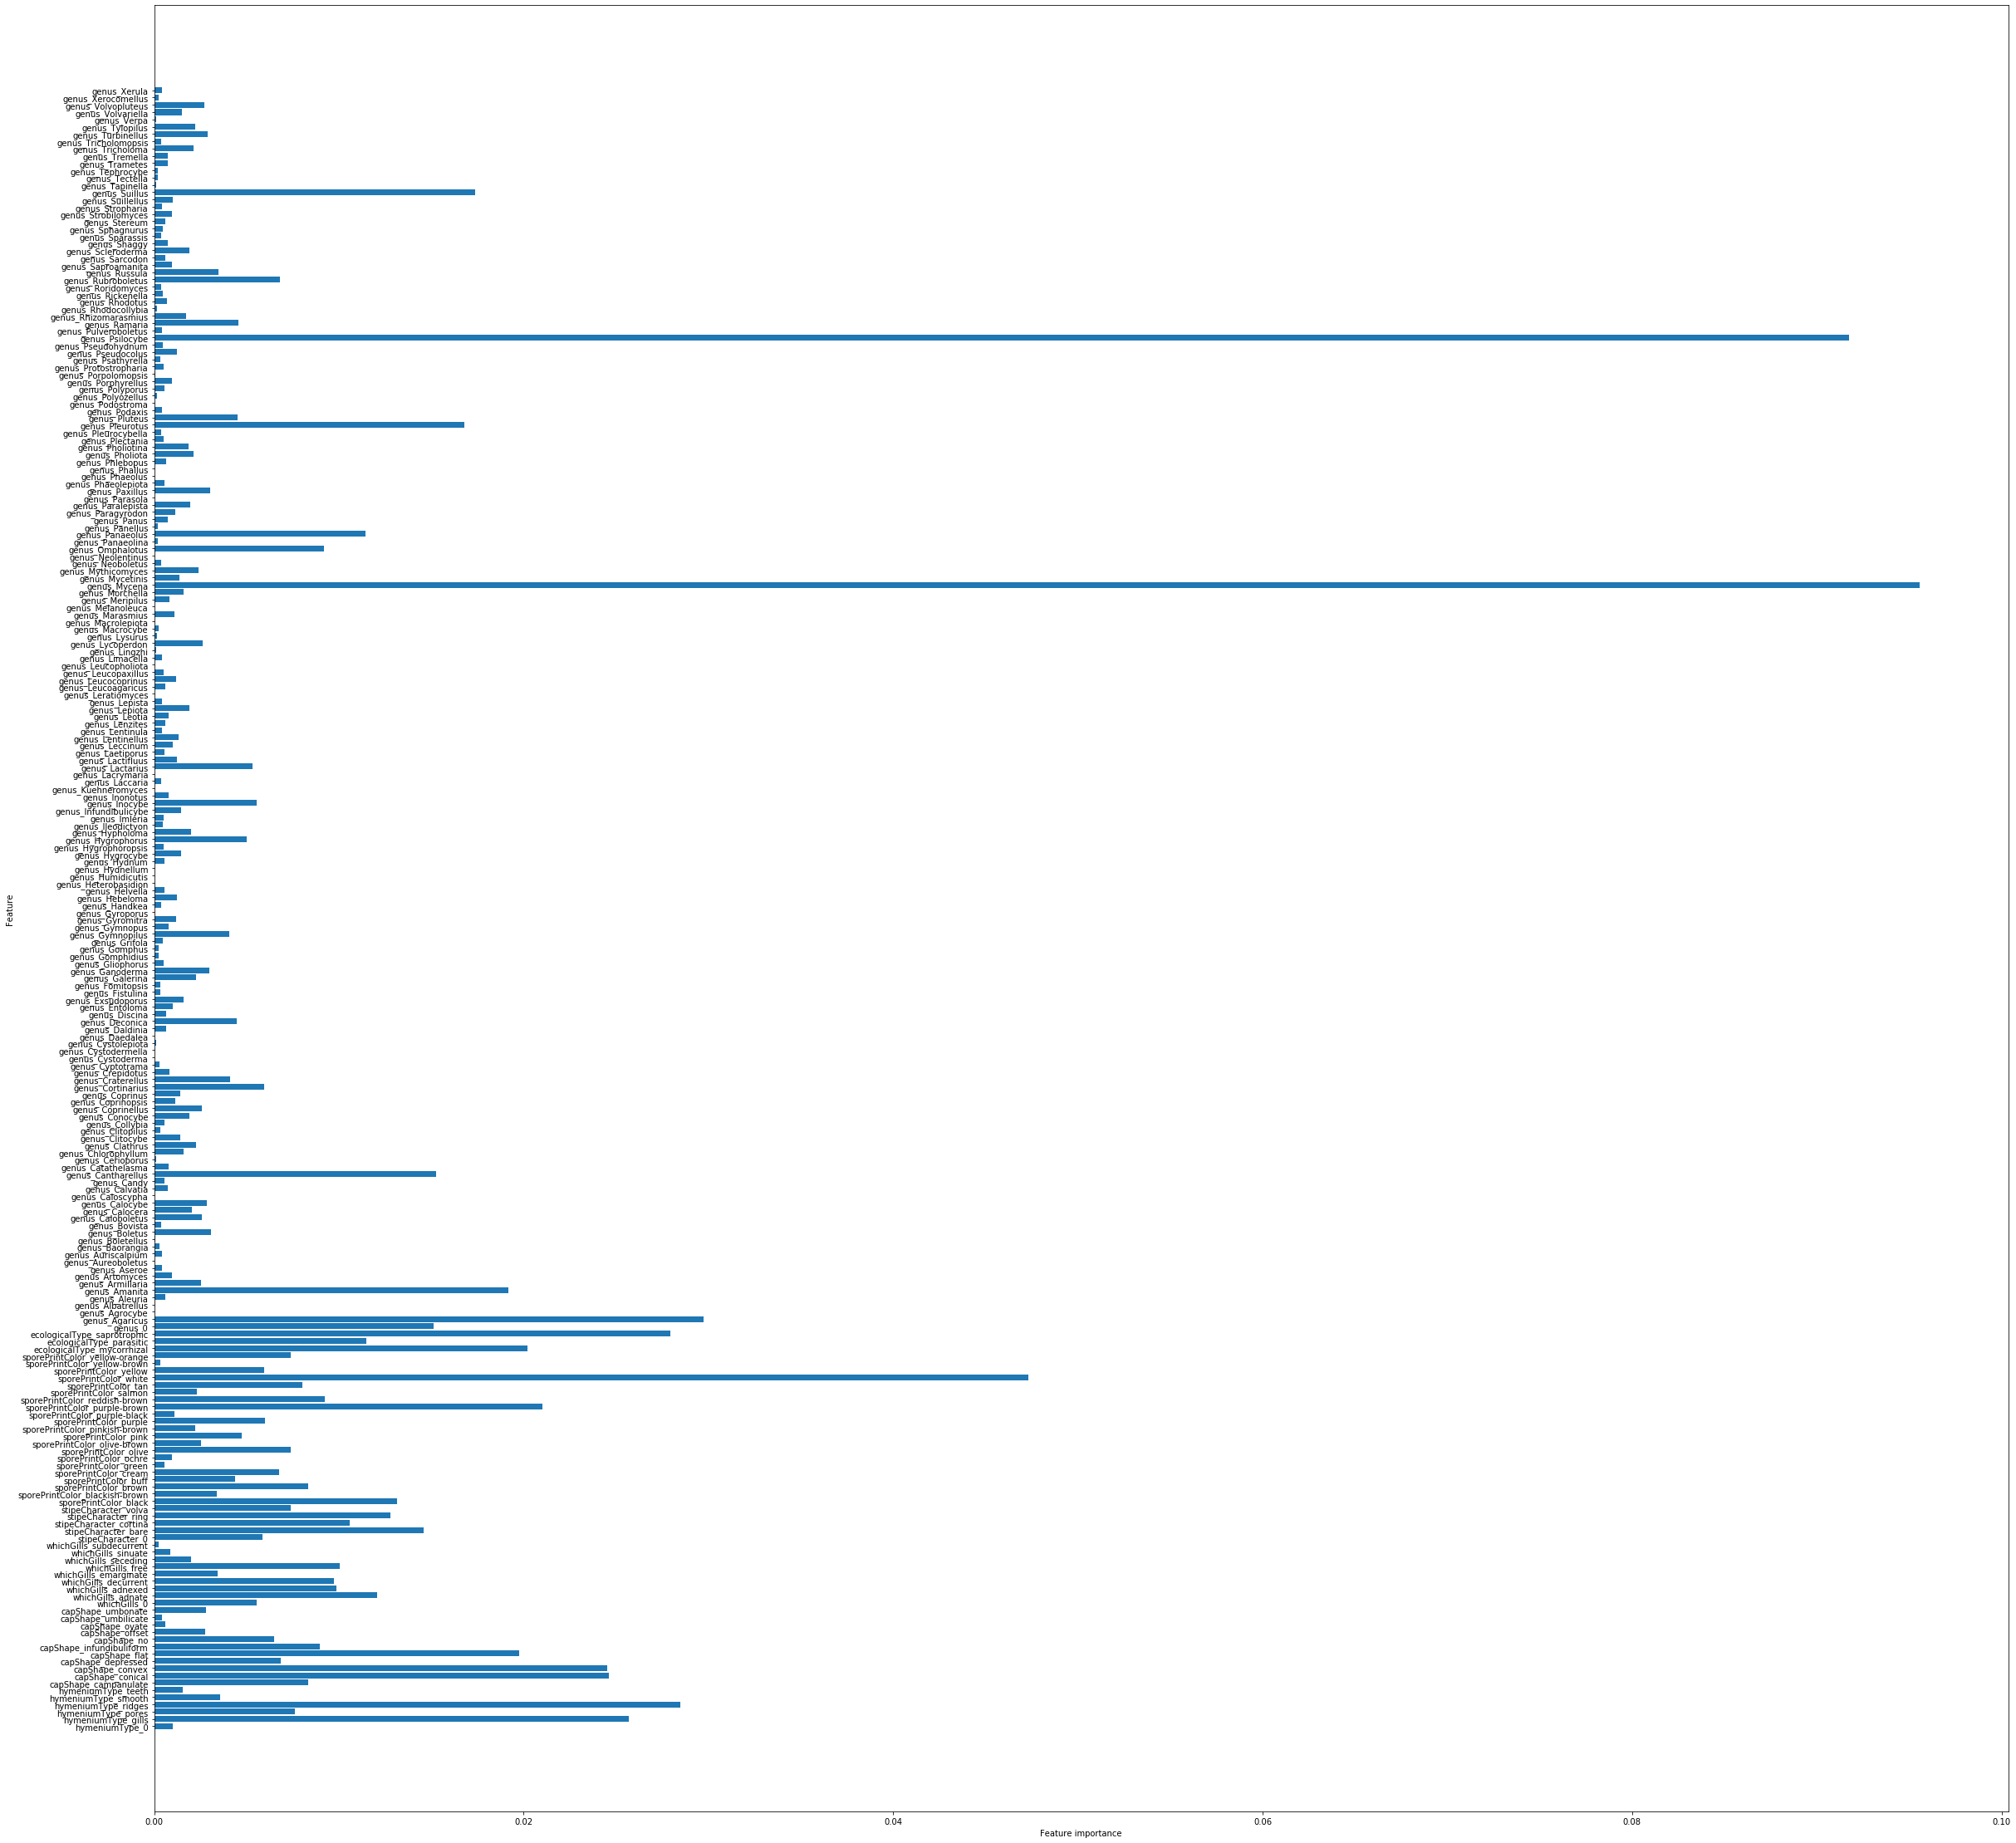

In [208]:
plot_feature_importances(forest)